In [ ]:
#| default_exp data.creation

In [ ]:
#| hide
# Mount Google Drive (Optional, but recommended for persistent storage)
from pathlib import Path

try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive mounted successfully.")
except ModuleNotFoundError:
    print("Not running in Colab, skipping Drive mount.")
except Exception as e:
    print(f"Error mounting Google Drive: {e}")

Mounted at /content/drive
Google Drive mounted successfully.


In [ ]:
#| export
try:
    import indic_clip.core
    print("Reloaded indic_clip.core")
except ModuleNotFoundError:
    print("indic_clip.core not found initially.")
    # Attempt to set sys.path if running in Colab and project cloned
    import sys
    if 'google.colab' in sys.modules:
        project_parent = '/content' # Assuming cloned into /content/indic-clip
        if Path('/content/drive/MyDrive/Indic-Clip').exists():
             project_parent = '/content/drive/MyDrive/Indic-Clip'
        if project_parent not in sys.path:
             sys.path.insert(0, project_parent)
             print(f"Added {project_parent} to sys.path")
        try:
            import indic_clip.core
            print("Imported indic_clip.core after path adjustment.")
        except ModuleNotFoundError:
            print("ERROR: Still cannot find indic_clip.core. Ensure project structure is correct.")
            print("Expected: /content/Indic-Clip/indic_clip/core.py or similar in Drive")
            # raise # Stop execution if core components missing

indic_clip.core not found initially.
Added /content/drive/MyDrive/Indic-Clip to sys.path
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive detected, setting PROJECT_ROOT to /content/drive/MyDrive/Indic-Clip
Ensure your project files are located there.
Imported indic_clip.core after path adjustment.


In [ ]:
#| hide
# !pip install -qr requirements.txt

In [ ]:
#| hide
%cd /content/drive/MyDrive/Indic-Clip/

/content/drive/MyDrive/Indic-Clip


In [ ]:
#| export
# --- Standard Library Imports ---
import os
import json
from pathlib import Path

# --- Pypi Library Imports ---
import pandas as pd
from PIL import Image

from fastcore.all import *

# --- fastai Imports ---
from fastai.vision.all import *
from fastai.data.all import *

# --- Project Imports ---
from indic_clip.core import *
from indic_clip.data.tokenization import IndicBERTTokenizer

PROCESSED_FILTERED_DATA_PATH = DATA_PATH / 'processed' / 'filtered_data.jsonl'
MAX_SEQ_LEN = 128
IMAGE_SIZE  = 256
BATCH_SIZE = DEFAULT_BATCH_SIZE

Reloaded indic_clip.core


In [ ]:
#| export
@patch
def summary(dblock:DataBlock):
    "Prints a summary of the DataBlock showing blocks, getters, and transforms."
    print(f"DataBlock Summary:")
    print(f"  Blocks: {dblock.blocks}")
    print(f"  Getters: {dblock.getters}")
    print(f"  Item Transforms: {dblock.item_tfms}")
    print(f"  Batch Transforms: {dblock.batch_tfms}")
    print(f"  Splitter: {dblock.splitter}")

In [ ]:
#| export
def get_indic_clip_items(data_path: Path = PROCESSED_FILTERED_DATA_PATH):
    """
    Loads image-caption pairs from a processed JSONL file.

    Args:
        data_path (Path): Path to the JSONL file. Each line should be a JSON object
                          containing at least 'source', 'image_path_relative', 'caption'.

    Returns:
        pandas.DataFrame: DataFrame containing the loaded data.
    """
    if not data_path.exists():
        raise FileNotFoundError(f"Processed data file not found at: {data_path}")

    data = []
    with open(data_path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                item = json.loads(line)
                # Basic validation
                if 'source' in item and 'image_path_relative' in item and 'caption' in item:
                    data.append(item)
                else:
                    print(f"Skipping invalid line: {line.strip()}") # Log or handle appropriately
            except json.JSONDecodeError:
                print(f"Skipping malformed JSON line: {line.strip()}") # Log or handle appropriately

    df = pd.DataFrame(data)
    print(f"Loaded {len(df)} items from {data_path}")
    # Example: Print first 5 rows and columns for inspection
    # print("Sample loaded data:")
    # print(df.head())
    # print("Columns:", df.columns)
    return df

In [ ]:
#| export
def ImageGetter(row):
    """
    Constructs the full path to an image file based on the 'source'
    and 'image_path_relative' fields in a DataFrame row.

    Args:
        row (pandas.Series or dict): A row from the DataFrame containing item info.

    Returns:
        Path: The absolute path to the image file.

    Raises:
        KeyError: If 'source' or 'image_path_relative' is missing in the row.
        ValueError: If the 'source' is not recognized (e.g., not 'flickr8k').
    """
    source = row['source']
    relative_path = row['image_path_relative']

    if source == 'flickr8k_hindi':
        base_path = HINDI_RAW_PATH # Adjust if folder structure changes
    # Add elif conditions for other sources (e.g., 'sanskrit_manuscript', 'ecommerce')
    # elif source == 'sanskrit_manuscript':
    #     base_path = SANSKRIT_RAW_PATH/'manuscripts' # Example path
    else:
        # Fallback or error for unknown source
        # Option 1: Raise an error
        raise ValueError(f"Unknown data source '{source}' encountered in row: {row}")
        # Option 2: Try a default path (less safe)
        # base_path = DATA_PATH/'raw'/'unknown_source'
        # print(f"Warning: Unknown source '{source}'. Assuming base path: {base_path}")

    full_path = base_path / relative_path

    # Optional: Check if the file exists here, although DataBlock usually handles it
    # if not full_path.exists():
    #     print(f"Warning: Image file not found at {full_path} for row: {row}")
    #     # Decide how to handle: skip item later, return None, etc.
    #     # Returning the path anyway and letting DataBlock handle it might be cleaner.

    return full_path

def CaptionGetter(row):
    """
    Extracts the caption from a DataFrame row.

    Args:
        row (pandas.Series or dict): A row from the DataFrame containing item info.

    Returns:
        str: The caption text.

    Raises:
        KeyError: If 'caption' is missing in the row.
    """
    return row['caption']

# Placeholder Getters for potential future use (Domain, Language)
def DomainGetter(row):
    """ Placeholder for extracting domain label """
    return row.get('domain', 'unknown') # Default if not present

def LanguageGetter(row):
    """ Placeholder for extracting language label """
    return row.get('language', 'un') # Default if not present

In [ ]:
#| export
class HFTextTransform(Transform):
    "Tokenize strings into a (ids,mask) tuple of Tensors."
    def __init__(self, hf_tokenizer):
        self.hf = hf_tokenizer

    def encodes(self, o:str):
        out = self.hf.tokenize(o)
        ids  = out['input_ids'].squeeze(0)
        mask = out['attention_mask'].squeeze(0)
        return ids, mask     # <-- pure Tensors only

    def decodes(self, o):
        # o will be a tuple of two Tensors
        ids, _ = o
        return self.hf.decode(ids.tolist(), skip_special_tokens=True)

In [ ]:
#| export
class IndicCLIPDataBlock(DataBlock):
    """
    A fast.ai DataBlock specifically designed for Indic-CLIP.
    Handles loading images and tokenizing corresponding text captions using
    a pre-trained Hugging Face tokenizer.

    Assumes input items are structured dicts or pandas rows containing
    'source', 'image_path_relative', and 'caption'.
    """
    def __init__(self,
                 tokenizer_name_or_path:str = PRETRAINED_TOKENIZER_NAME,
                 tokenizer_save_path:Path = TOKENIZER_PATH,
                 vocab_size:int = None, # Auto-detected if None
                 max_length:int = MAX_SEQ_LEN,
                 img_size:int = IMAGE_SIZE,
                 valid_pct:float = 0.1,
                 seed:int = 42,
                 batch_size:int = BATCH_SIZE,
                 num_workers:int = 4,
                 use_augmentations:bool = True,
                 **db_kwargs): # Pass other DataBlock args
        """
        Initializes the IndicCLIPDataBlock.

        Args:
            tokenizer_name_or_path (str): Name/path of the Hugging Face tokenizer.
            tokenizer_save_path (Path): Path to save/load the tokenizer state.
            vocab_size (int, optional): Expected vocabulary size. Auto-detected if None.
            max_length (int): Maximum sequence length for tokenization.
            img_size (int): Size to resize images to (square).
            valid_pct (float): Percentage of data to use for validation.
            seed (int): Random seed for splitting.
            batch_size (int): DataLoader batch size.
            num_workers (int): Number of worker processes for DataLoader.
            use_augmentations (bool): Whether to apply image augmentations.
            custom_tokenizer_cls: The tokenizer wrapper class to use.
            **db_kwargs: Additional keyword arguments for the parent DataBlock.
        """
        self.max_length = max_length
        self.tokenizer = IndicBERTTokenizer.load_tokenizer(tokenizer_save_path, max_length=self.max_length)
        if vocab_size is not None and self.tokenizer.vocab_size != vocab_size:
             print(f"Warning: Provided vocab_size ({vocab_size}) does not match tokenizer's vocab_size ({self.tokenizer.vocab_size}). Using tokenizer's value.")
        self.vocab_size = self.tokenizer.vocab_size # Store actual vocab size
        self.img_size = img_size
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Define the text block using TransformBlock and the loaded tokenizer
        # The tokenizer __call__ handles padding and truncation directly

        text_block = TransformBlock(type_tfms=HFTextTransform(self.tokenizer))

        # Define image augmentations
        batch_tfms_list = []
        if use_augmentations:
             # Default aug_transforms includes random resizing, flips, brightness, contrast etc.
             # Customize as needed: aug_transforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
            # batch_tfms_list.append(aug_transforms(size=self.img_size))
            batch_tfms_list += aug_transforms(size=self.img_size)
        # Always add normalization
        batch_tfms_list.append(Normalize.from_stats(*imagenet_stats))


        # Initialize the DataBlock
        # For contrastive learning, y is usually not needed directly from the dataloader
        # The pairing is implicit in the batch (image i corresponds to text i)
        super().__init__(
            blocks=(ImageBlock, text_block), # ImageBlock output: Tensor; text_block output: (Tensor, Tensor)
            n_inp=2,                          # Tell DataBlock the first 2 blocks are inputs
            # get_items=get_indic_clip_items,   # Function to get the source data (e.g., dataframe)
            get_x=[ImageGetter,             # Function to get the image path from item
                   CaptionGetter],          # Function to get the caption string from item
            # No get_y needed for self-supervised contrastive learning
            splitter=RandomSplitter(valid_pct=valid_pct, seed=seed),
            item_tfms=Resize(self.img_size),  # Transform applied to individual items
            batch_tfms=batch_tfms_list,       # Transform applied to batches
            **db_kwargs
        )


    def get_dataloaders(self, source_items, **kwargs):
        """
        Creates DataLoaders from the provided source items.

        Args:
            source_items (list or pd.DataFrame): The list of items (dicts or rows).
            **kwargs: Additional arguments passed to dataloaders method.

        Returns:
            DataLoaders: The fastai DataLoaders object.
        """
        # Set default batch size and num_workers if not overridden
        kwargs.setdefault('bs', self.batch_size)
        kwargs.setdefault('num_workers', self.num_workers)

        print(f"Creating DataLoaders with bs={kwargs['bs']}, num_workers={kwargs['num_workers']}")
        return self.dataloaders(source_items, **kwargs)

In [ ]:
import matplotlib.font_manager as fm

# adjust this path to wherever NotoSansDevanagari-Regular.ttf lives on your system
font_path = "NotoSansDevanagari.ttf"
# Add the font to the font manager
fm.fontManager.addfont(font_path)

if not fm.findfont(fm.FontProperties(fname=font_path), rebuild_if_missing=False):
    raise FileNotFoundError(f"Could not find Devanagari font at {font_path}")

deva_prop = fm.FontProperties(fname=font_path)

def show_batch_with_captions(dls, hf_wrapper, max_n=4):
    "Show a batch of images + decoded captions. `hf_wrapper` is your IndicBERTTokenizer instance."
    xb, yb = dls.one_batch()
    ids, mask = yb              # assume yb is a (batch_ids, batch_mask) tuple
    mean, std = imagenet_stats

    bs = xb.shape[0]
    n  = min(bs, max_n)
    fig,axes = plt.subplots(1, n, figsize=(n*3, 3))
    if n==1: axes = [axes]

    for i,ax in enumerate(axes):
        # 1) Denormalize & clamp
        img = xb[i] * torch.tensor(std, device=xb.device).view(3,1,1) \
                   + torch.tensor(mean, device=xb.device).view(3,1,1)
        img = img.clamp(0,1).permute(1,2,0).cpu().numpy()
        ax.imshow(img); ax.axis('off')

        # 2) Only keep the real tokens (mask==1)
        valid_ids = ids[i][mask[i].bool()].cpu().tolist()

        # 3) Decode to text
        txt = hf_wrapper.decode(valid_ids)

        ax.set_title(txt, fontproperties=deva_prop, wrap=True)

    plt.tight_layout()
    plt.show()

Loaded 8006 items from /content/drive/MyDrive/Indic-Clip/data/processed/filtered_data.jsonl

Successfully loaded 8006 items.
Sample item (first row):
image_path_relative                                              Images/1000268201_693b08cb0e.jpg
caption                गुलाबी पोशाक में बच्चा प्रवेश के रास्ते में सीढ़ियों के सेट पर चढ़ रहा है।
source                                                                             flickr8k_hindi
Name: 0, dtype: object

Instantiating IndicCLIPDataBlock...


2025-04-18 12:34:48 - indic_clip.data.tokenization - INFO - Successfully loaded tokenizer: /content/drive/MyDrive/Indic-Clip/models/tokenizer
2025-04-18 12:34:48 - indic_clip.data.tokenization - INFO - Custom special tokens already exist or none were specified.
2025-04-18 12:34:48 - indic_clip.data.tokenization - INFO - Tokenizer state loaded successfully from /content/drive/MyDrive/Indic-Clip/models/tokenizer


DataBlock Summary:
  Blocks: (<class 'fastai.data.block.TransformBlock'>, <class 'fastai.data.block.TransformBlock'>)
  Getters: [<function ImageGetter>, <function CaptionGetter>]
  Item Transforms: [ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
decodes: , Resize -- {'size': (256, 256), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (<Resampling.BILINEAR: 2>, <Resampling.NEAREST: 0>), 'p': 1.0}:
encodes: (Image,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decodes: ]
  Batch Transforms: [IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
decodes: (TensorImage,object) -> decodes
, Flip -- {'size': 256, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 0.5}:
encodes: (TensorImage,object) -> encodes
(TensorMask,object) -> encodes
(TensorBBox,object) -> encodes
(TensorPoint,object) -> encodes
decod

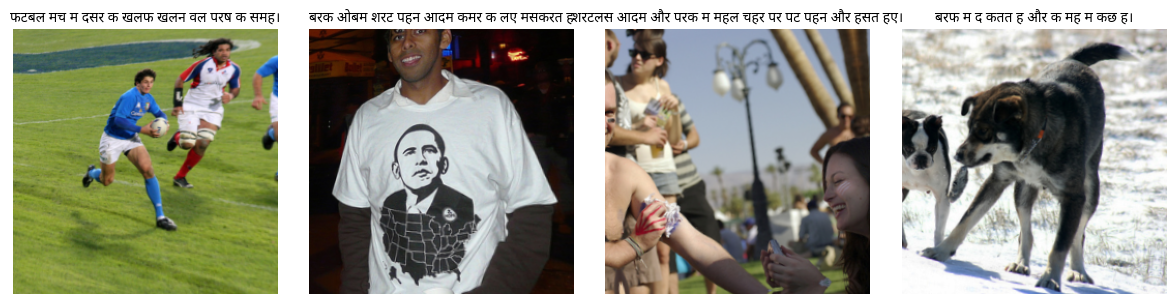

In [ ]:
# Example Usage & Testing

# 1. Load the items
try:
    items_df = get_indic_clip_items()
    print(f"\nSuccessfully loaded {len(items_df)} items.")
    print("Sample item (first row):")
    print(items_df.iloc[0])

    # 2. Instantiate the DataBlock
    print("\nInstantiating IndicCLIPDataBlock...")
    indic_clip_dblock = IndicCLIPDataBlock(
        # Override defaults if needed
        # valid_pct=0.05,
        batch_size=4, # Use a small batch size for testing
        num_workers=0 if os.name == 'nt' else 2 # Avoid issues on Windows
    )
    indic_clip_dblock.summary()
    print(f"Using Tokenizer: {indic_clip_dblock.tokenizer.tokenizer_name}")
    print(f"Tokenizer Vocab Size: {indic_clip_dblock.vocab_size}")
    print(f"Max Sequence Length: {indic_clip_dblock.max_length}")
    print(f"Image Size: {indic_clip_dblock.img_size}")

    # 3. Create DataLoaders
    print("\nCreating DataLoaders...")
    # Pass the DataFrame directly as source
    dls = indic_clip_dblock.get_dataloaders(items_df)
    print("DataLoaders created successfully.")

    # 4. Inspect a batch
    print("\nInspecting one batch...")
    batch = dls.one_batch()
    # print(f"Batch type: {type(batch)}")
    # print(f"Batch length (number of tensors): {len(batch)}") # Should be 2 (images, texts) or more if get_y is used

    img_batch, txt_batch = batch[0], batch[1]
    # print(f"\nImage Batch Type: {type(img_batch)}")
    print(f"Image Batch Shape: {img_batch.shape}") # Expected: [bs, 3, img_size, img_size]
    print(f"Image Batch dtype: {img_batch.dtype}")

    # The text batch from TransformBlock containing tokenizer output
    # is usually a tuple or dict: (input_ids, attention_mask)
    # print(f"\nText Batch Type: {type(txt_batch)}")
    # Depending on how tokenizer returns:
    if isinstance(txt_batch, dict):
        print(f"Text Batch Keys: {txt_batch.keys()}")
        print(f"Text Batch input_ids Shape: {txt_batch['input_ids'].shape}") # Expected: [bs, max_length]
        print(f"Text Batch attention_mask Shape: {txt_batch['attention_mask'].shape}") # Expected: [bs, max_length]
        print(f"Text Batch input_ids dtype: {txt_batch['input_ids'].dtype}")
    elif isinstance(txt_batch, tuple):
         print(f"Text Batch is a tuple of length: {len(txt_batch)}")
         print(f"Text Batch[0] (input_ids?) Shape: {txt_batch[0].shape}")
         print(f"Text Batch[1] (attn_mask?) Shape: {txt_batch[1].shape}")
         print(f"Text Batch[0] dtype: {txt_batch[0].dtype}")
    else:
        print(f"Text Batch Shape: {txt_batch.shape}") # If it's just one tensor
        print(f"Text Batch dtype: {txt_batch.dtype}")


    # Basic Assertions
    assert img_batch.shape[0] == indic_clip_dblock.batch_size
    assert img_batch.shape[1] == 3
    assert img_batch.shape[2] == indic_clip_dblock.img_size
    assert img_batch.shape[3] == indic_clip_dblock.img_size
    assert img_batch.dtype == torch.float32

    if isinstance(txt_batch, dict):
        assert txt_batch['input_ids'].shape[0] == indic_clip_dblock.batch_size
        assert txt_batch['input_ids'].shape[1] <= indic_clip_dblock.max_length # Should be == max_length if padding works
        assert txt_batch['attention_mask'].shape[0] == indic_clip_dblock.batch_size
        assert txt_batch['attention_mask'].shape[1] == txt_batch['input_ids'].shape[1]
        assert txt_batch['input_ids'].dtype == torch.int64
    elif isinstance(txt_batch, tuple):
        assert txt_batch[0].shape[0] == indic_clip_dblock.batch_size
        assert txt_batch[0].shape[1] <= indic_clip_dblock.max_length
        assert txt_batch[1].shape[0] == indic_clip_dblock.batch_size
        assert txt_batch[1].shape[1] == txt_batch[0].shape[1]
        assert txt_batch[0].dtype == torch.int64

    print("\nBatch structure seems correct.")

    # 5. Show a batch (optional, might need adjustments for text tensors)
    print("\nShowing a batch (visualization might be basic for text)...")
    show_batch_with_captions(dls, indic_clip_dblock.tokenizer, max_n=4)
    # dls.show_batch(max_n=4, figsize=(8,8)) # Requires show methods for text tensors

except FileNotFoundError as e:
    print(f"\nError: {e}")
    print("Please ensure the filtered data file exists at the expected location:")
    print(f"Expected location: {PROCESSED_FILTERED_DATA_PATH}")
    print("You might need to run the preprocessing notebook (02_*.ipynb) first.")
except Exception as e:
    print(f"\nAn unexpected error occurred: {e}")
    import traceback
    traceback.print_exc()

In [ ]:
#| hide
%cd /content/drive/MyDrive/Indic-Clip
import nbdev
nbdev.nbdev_export() # Run this in terminal to export